In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
from bold_dementia.data.study import balance_control
from bold_dementia.connectivity import Atlas, fast_hist, reshape_pvalues, vec_idx_to_mat_idx, z_transform_to_vec
from bold_dementia.data.volumes import add_volumes

import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from joblib import Parallel, delayed


from formulaic import model_matrix
from scipy.stats import ttest_ind

ATLAS = "gillig"
SOFT = False
pd.options.mode.copy_on_write = True
MACRO_LABELS = False

if MACRO_LABELS:
    from bold_dementia.connectivity import plot_matrix
else:
    from bold_dementia.connectivity import plot_ordered_matrix as plot_matrix # TODO This could be better

In [2]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_inter-networks-m5n33"
)
print(f"Fetching data in {matrices_path}")
# TODO Intracranial volume
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
atlas = Atlas.from_name(ATLAS, SOFT)

Fetching data in /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-gillig_inter-networks-m5n33


In [3]:
AD_vec = np.array([z_transform_to_vec(mat) for mat in AD_matrices])
control_vec = np.array([z_transform_to_vec(mat) for mat in control_matrices])

In [4]:
# TODO Check order consistency in scripts before
AD_df = pd.read_csv(matrices_path / "balanced_AD.csv", index_col=0)
control_df = pd.read_csv(matrices_path / "balanced_control.csv", index_col=0)
df = pd.concat((AD_df, control_df))

In [5]:
fc = np.vstack((AD_vec, control_vec))
l = fc.shape[1]
labels = atlas.labels
rows, cols = vec_idx_to_mat_idx(l)
edges = [f"{labels[i]}_{labels[j]}" for i, j in zip(rows, cols)]

fc = pd.DataFrame(fc, columns=edges)

df["AD"] = np.where(df.scan_to_onset < 0, 1, 0)
df = pd.concat([df.reset_index(drop=True), fc], axis=1, join="inner")
df = df.drop(df[df.MA == 0].index) # Drop MA == 0
df = add_volumes(df, config["volumes"])

cleaned_df = df.dropna(subset="APOE_eps4")

## Visualisation of covariates 

### Age

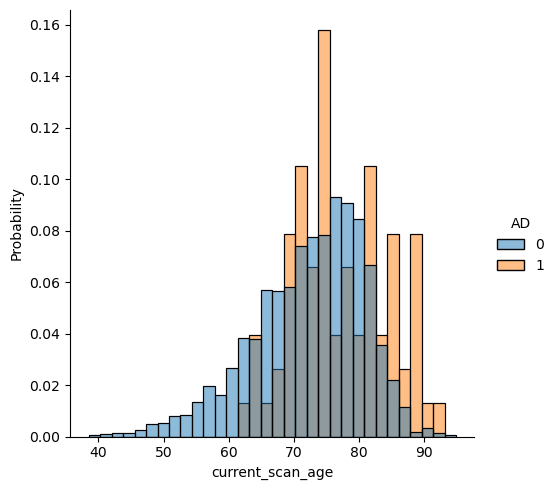

In [6]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    stat="probability",
    common_norm=False,
)
plt.show()

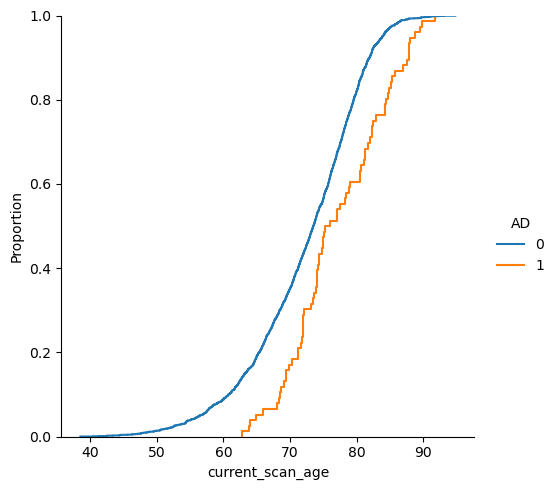

In [7]:
sns.displot(
    df,
    x="current_scan_age",
    hue="AD",
    kind="ecdf",
)
plt.show()

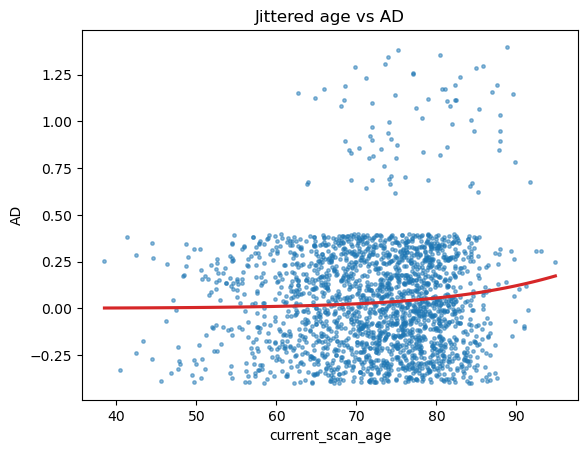

In [8]:
sns.regplot(
    df,
    x="current_scan_age", 
    y="AD",
    logistic=True,
    ci=None,
    line_kws={"color":"tab:red"}, 
    scatter_kws={"alpha": 0.5, "s":6},
    y_jitter=0.4,
)
plt.title("Jittered age vs AD")
plt.show()

### APOE allele

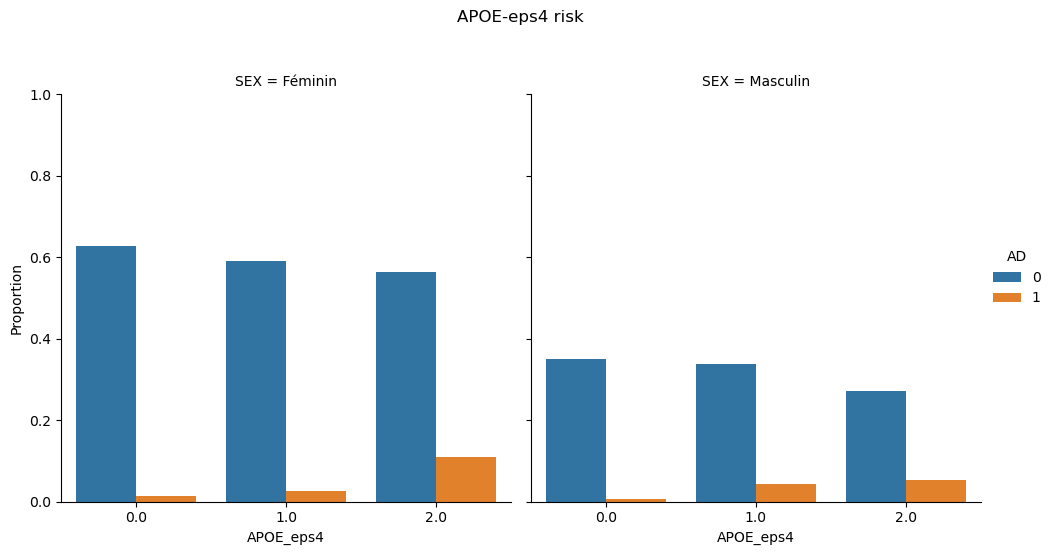

In [9]:
x, y = 'APOE_eps4', "AD"
f = (cleaned_df.groupby(x)[[y, "SEX"]]
.value_counts(normalize=True)
.rename('Proportion')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='Proportion',hue=y,kind='bar', col="SEX"))
plt.ylim(0, 1)
plt.suptitle("APOE-eps4 risk", y=1.1)
plt.show()

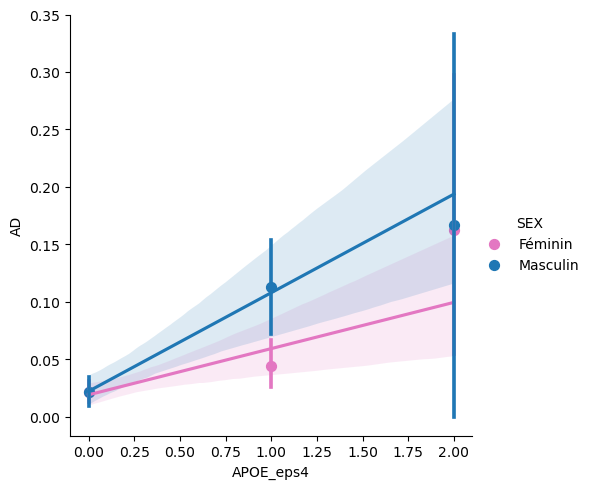

In [10]:
sns.lmplot(
    y="AD",
    x="APOE_eps4",
    data=cleaned_df,
    x_estimator=np.mean,
    #logistic=True,
    hue="SEX",
    palette=["tab:pink", "tab:blue"]
)
plt.show()

## Model fitting

In [11]:
tst_edge_name = edges[0]
test_df = df.groupby("sub").sample(n=1).dropna(subset="NIVETUD")
lhs, rhs = model_matrix(f"`{tst_edge_name}` ~ AD + scale(current_scan_age) + SEX + NIVETUD + scale(`total intracranial`)", test_df)

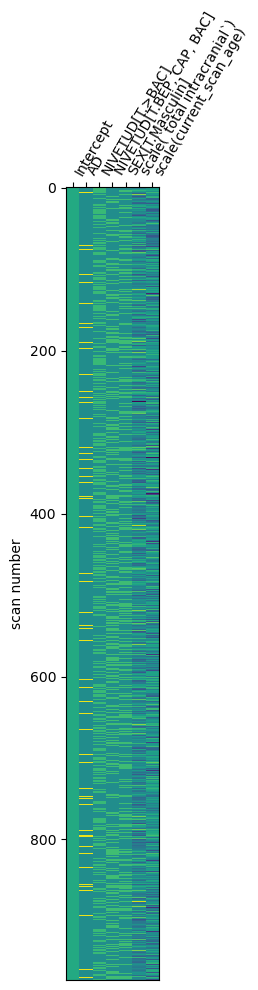

In [12]:
from nilearn import plotting

# TODO Plot design matrix
plotting.plot_design_matrix(rhs)
plotting.show()


In [13]:
import statsmodels.formula.api as smf

#model = sm.OLS(endog=lhs, exog=rhs)
model = sm.MixedLM(
    endog=lhs,
    exog=rhs,
    groups=test_df["CEN_ANOM"],
)
result = model.fit(method="bfgs")
result.summary()

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM     Dependent Variable:     RSN02_RSN01
No. Observations:      973         Method:                 REML       
No. Groups:            25          Scale:                  0.0210     
Min. group size:       1           Log-Likelihood:         468.7119   
Max. group size:       234         Converged:              Yes        
Mean group size:       38.9                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.078    0.012  6.366 0.000  0.054  0.102
AD                          -0.027    0.020 -1.350 0.177 -0.066  0.012
NIVETUD[T.>BAC]              0.026    0.012  2.082 0.037  0.002  0.050
NIVETUD[T.BEP, CAP, BAC]     0.032    0.013  2.544 0.011  0.007  0.057
SEX[T.Masculin]              0.004    0.013  0.283 0.777 -0.021  0.029
scale(`total intracranial`)  0.004    0.006  0.620 0.535 -0.008  0.016
scale(current_scan_age)      0.004    0.005  0.829 0.407 -0.006  0.014
Group Var                    0.001    0.003                           
======================================================================

"""

In [14]:
# TODO Return more fitting info
# TODO CEN_ANOM as random effect?
def fit_edges(ROI_name, dataframe):
    lhs, rhs = model_matrix(f"`{ROI_name}` ~ AD + scale(current_scan_age) + SEX + NIVETUD", dataframe)
    model = sm.MixedLM(endog=lhs, exog=rhs, groups=dataframe["CEN_ANOM"])
    try:
        result = model.fit(method="bfgs") # TODO Explore method influence
        return result.params.AD, result.pvalues.AD
    except np.linalg.LinAlgError:
        return np.nan, np.nan
    

In [15]:
fit_df = lambda edge: fit_edges(edge, test_df)

In [17]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
parallel = Parallel(n_jobs=8, verbose=2)
test_results = parallel(delayed(fit_df)(edge) for edge in edges)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warni

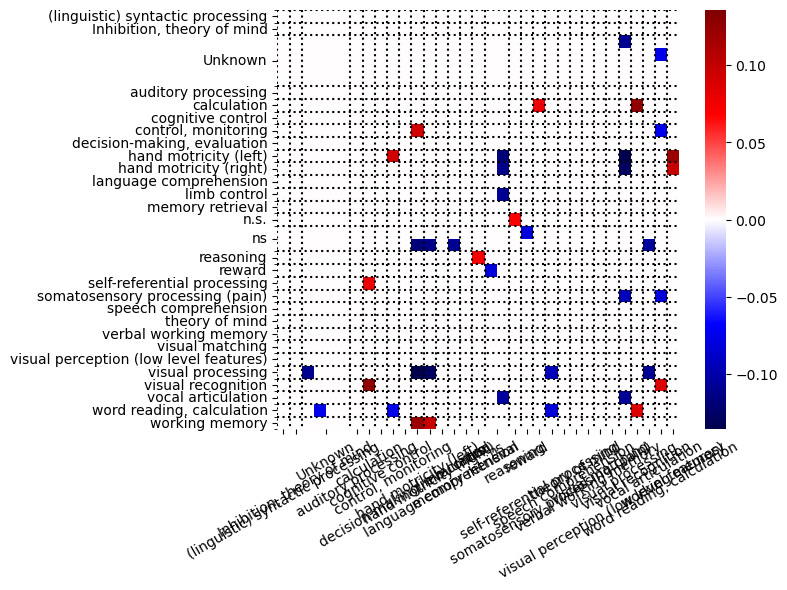

In [18]:
from bold_dementia.connectivity import plot_matrix
stats = [tr[0] for tr in test_results]
pvalues = [tr[1] for tr in test_results]
_, pvalues_corr = fdrcorrection(pvalues)

statmat = reshape_pvalues(stats)

pmat = reshape_pvalues(pvalues_corr)
display_mat = np.where(pmat < config["alpha"], statmat, 0)

plot_matrix(display_mat, atlas=atlas)
plt.show()

In [ ]:
joblib.dump(statmat, matrices_path / "EFW_glm_stat.joblib")
joblib.dump(pmat, matrices_path / "EFW_glm_pvalues.joblib")

['/homes_unix/jlegrand/data/Memento/output/connectivity/atlas-schaeffer200_DEBUG_default/glm_pvalues.joblib']

In [ ]:
from nilearn import plotting
coords = atlas.get_coords()

view = plotting.view_connectome(display_mat, coords)
view.open_in_browser()

### Assumptions on residuals

In [19]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(result)

AttributeError: 'MixedLMResults' object has no attribute 'mse_resid'

#### Normality

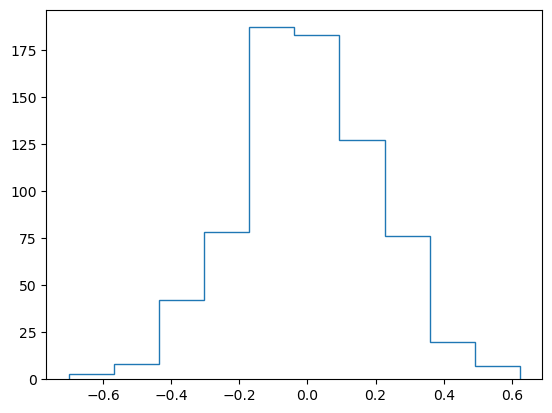

In [ ]:
plt.hist(result.resid, histtype="step")
plt.show()

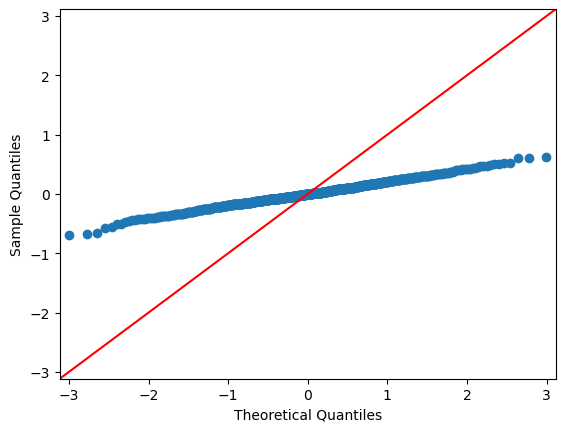

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot(influence.resid, line="45")
plt.show()

#### Homoskedasticity

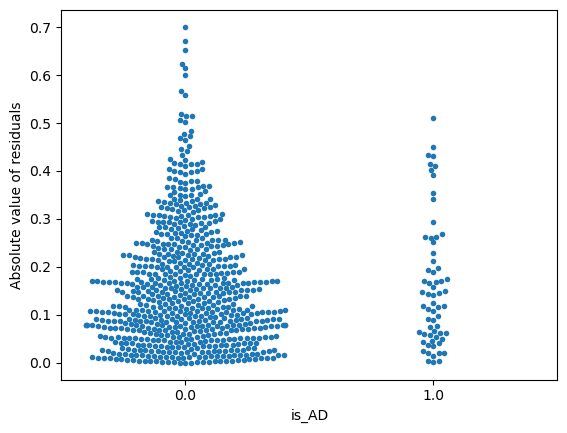

In [ ]:
# Spread Location plot
sns.swarmplot(
    x=model.exog[:, 1],
    y=abs(result.resid),
    size=4
)
plt.xlabel("is_AD")
plt.ylabel("Absolute value of residuals")
plt.show()

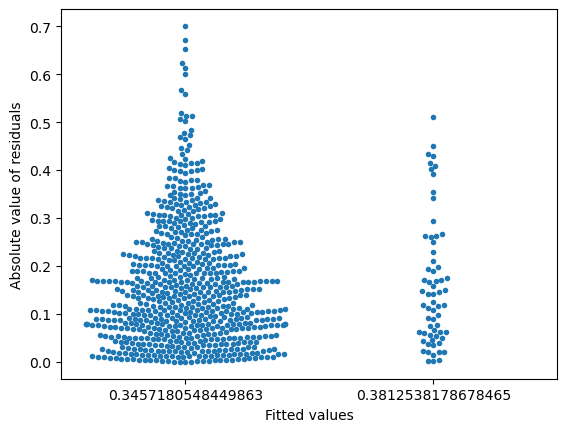

In [ ]:
sns.swarmplot(
    x=result.fittedvalues,
    y=abs(result.resid),
    size=4
)
plt.xlabel("Fitted values")
plt.ylabel("Absolute value of residuals")
plt.show()

#### Linearity

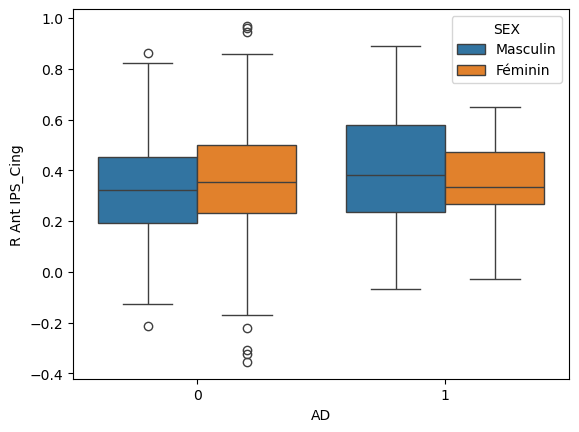

In [ ]:
# Linearity holds for categorical features
sns.boxplot(
    df,
    x="AD",
    y=tst_edge_name,
    hue="SEX"
)
plt.show()